# **Analysis using Random Forest**

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

In [86]:
from sklearn.ensemble import RandomForestClassifier

# Load training data
rf_df = pd.read_csv("Train_data.csv").drop_duplicates()

# Features and target
rf_X = rf_df.drop("class", axis=1)
rf_y = rf_df["class"]

# Identify feature types
rf_num_features = rf_X.select_dtypes(include=["int64","float64"]).columns
rf_cat_features = rf_X.select_dtypes(include=["object"]).columns

# Preprocessing
rf_num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
rf_cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
rf_preprocessor = ColumnTransformer([
    ("num", rf_num_transformer, rf_num_features),
    ("cat", rf_cat_transformer, rf_cat_features)
])

# Train-test split
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(
    rf_X, rf_y, test_size=0.2, stratify=rf_y, random_state=42)

# Pipeline with Random Forest
rf_clf = Pipeline([
    ("preprocessor", rf_preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit and predict
rf_clf.fit(rf_X_train, rf_y_train)
rf_pred = rf_clf.predict(rf_X_test)

# Metrics
rf_precision = precision_score(rf_y_test, rf_pred, pos_label="anomaly")
rf_recall = recall_score(rf_y_test, rf_pred, pos_label="anomaly")
rf_f1 = f1_score(rf_y_test, rf_pred, pos_label="anomaly")


# **Analysis using Isolation Forest**

In [87]:
from sklearn.ensemble import IsolationForest

iso_df = pd.read_csv("Train_data.csv").drop_duplicates()
iso_X = iso_df.drop("class", axis=1)
iso_y = iso_df["class"]

# Preprocess
iso_num_features = iso_X.select_dtypes(include=["int64","float64"]).columns
iso_cat_features = iso_X.select_dtypes(include=["object"]).columns

iso_num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
iso_cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
iso_preprocessor = ColumnTransformer([
    ("num", iso_num_transformer, iso_num_features),
    ("cat", iso_cat_transformer, iso_cat_features)
])

iso_X_processed = iso_preprocessor.fit_transform(iso_X)

# Train Isolation Forest
iso_model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_model.fit(iso_X_processed)

# Predict anomalies
iso_pred = iso_model.predict(iso_X_processed)  # -1 = anomaly, 1 = normal
iso_labels = ["anomaly" if p == -1 else "normal" for p in iso_pred]

# Metrics (if labels available)
iso_precision = precision_score(iso_y, iso_labels, pos_label="anomaly")
iso_recall = recall_score(iso_y, iso_labels, pos_label="anomaly")
iso_f1 = f1_score(iso_y, iso_labels, pos_label="anomaly")


# **Analysis using Self Organizing Maps**

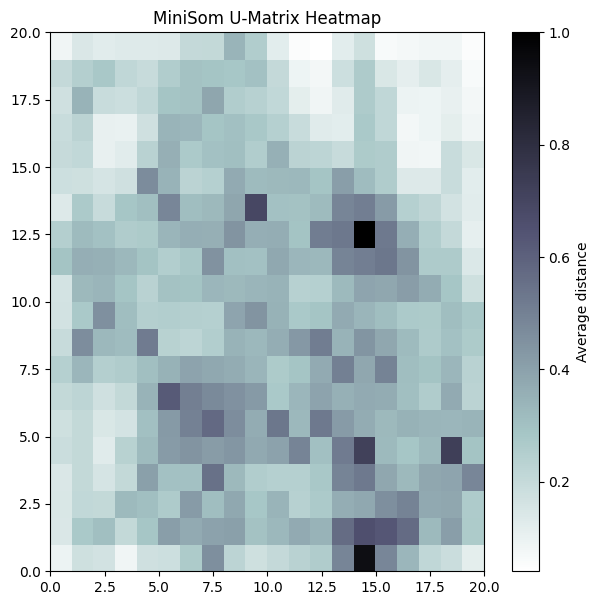

In [88]:
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt

som_df = pd.read_csv("Train_data.csv").drop_duplicates()
som_X = som_df.drop("class", axis=1)
som_y = som_df["class"]

# Preprocess
som_num_features = som_X.select_dtypes(include=["int64","float64"]).columns
som_cat_features = som_X.select_dtypes(include=["object"]).columns

som_num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
som_cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
som_preprocessor = ColumnTransformer([
    ("num", som_num_transformer, som_num_features),
    ("cat", som_cat_transformer, som_cat_features)
])

som_X_processed = som_preprocessor.fit_transform(som_X)

# Train SOM
som = MiniSom(x=20, y=20, input_len=som_X_processed.shape[1],
              sigma=1.0, learning_rate=0.5, random_seed=42)
som.random_weights_init(som_X_processed)
som.train_random(som_X_processed, num_iteration=1000)

# Quantization error anomaly detection
som_errors = np.array([som.quantization_error([x]) for x in som_X_processed])
threshold = som_errors.mean() + 2*som_errors.std()
som_labels = ["anomaly" if e > threshold else "normal" for e in som_errors]

# Metrics
som_precision = precision_score(som_y, som_labels, pos_label="anomaly")
som_recall = recall_score(som_y, som_labels, pos_label="anomaly")
som_f1 = f1_score(som_y, som_labels, pos_label="anomaly")

# Plot U-Matrix heatmap
plt.figure(figsize=(7,7))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # distance_map() gives U-Matrix
plt.colorbar(label="Average distance")
plt.title("MiniSom U-Matrix Heatmap")
plt.show()


# **Analysis using Gaussian Mixture Model**

In [89]:
from sklearn.mixture import GaussianMixture

# Load and preprocess
gmm_df = pd.read_csv("Train_data.csv").drop_duplicates()
gmm_X = gmm_df.drop("class", axis=1)
gmm_y = gmm_df["class"]

# Preprocess (same as before)
gmm_num_features = gmm_X.select_dtypes(include=["int64","float64"]).columns
gmm_cat_features = gmm_X.select_dtypes(include=["object"]).columns

gmm_num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
gmm_cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
gmm_preprocessor = ColumnTransformer([
    ("num", gmm_num_transformer, gmm_num_features),
    ("cat", gmm_cat_transformer, gmm_cat_features)
])

gmm_X_processed = gmm_preprocessor.fit_transform(gmm_X)

# Fit GMM (choose number of components, e.g. 2 for normal vs anomaly)
gmm_model = GaussianMixture(n_components=2, covariance_type="full", random_state=42)
gmm_model.fit(gmm_X_processed)

# Compute log-likelihood scores
log_probs = gmm_model.score_samples(gmm_X_processed)

# Threshold: mean - 2*std (tune as needed)
threshold = log_probs.mean() - 2*log_probs.std()
gmm_labels = ["anomaly" if lp < threshold else "normal" for lp in log_probs]

# Metrics
gmm_precision = precision_score(gmm_y, gmm_labels, pos_label="anomaly")
gmm_recall = recall_score(gmm_y, gmm_labels, pos_label="anomaly")
gmm_f1 = f1_score(gmm_y, gmm_labels, pos_label="anomaly")


# **Comparing all of our models**

In [90]:
results = pd.DataFrame({
    "Model": ["Random Forest", "Isolation Forest", "MiniSom", "Gaussian Mixture Model"],
    "Precision": [rf_precision, iso_precision, som_precision, gmm_precision],
    "Recall": [rf_recall, iso_recall, som_recall, gmm_recall],
    "F1-Score": [rf_f1, iso_f1, som_f1, gmm_f1]
})

print(results)


                    Model  Precision    Recall  F1-Score
0           Random Forest   0.999146  0.995743  0.997441
1        Isolation Forest   0.709012  0.152091  0.250456
2                 MiniSom   0.288136  0.002895  0.005733
3  Gaussian Mixture Model   0.531008  0.011667  0.022831


Seems like Random Forest Beats them all with high margin.